*Copyright (C) 2021-2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# Solving Quadratic Programs with Lava and Loihi

Quadratic Programs can be solved using a first-order update scheme called PIPGeq [1]  (Proportional Integral Projected Gradient), an algorithm to solve equality constrained Quadratic Programs. It has been designed keeping edge-level MPC in mind. <br>
The scope for parallelization in these kinds of problems along with the sparsity in connectivity, make it an ideal class of problems that can be solved on Loihi. In this tutorial We shall explore how this solver is used in the Lava framework in the optimization library with a floating-point CPU backend and also how the solver currently runs on Loihi 2, thereby demonstrating the first known QP solver on neuromorphic hardware.

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Quadratic Programming in Lava](https://github.com/lava-nc/lava-optimization/blob/main/tutorials/tutorial_01_solving_lasso.ipynb)

### PIPG to solve QPs on Loihi 2

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The decay/growth parameters are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

#### Load Data

We use data from 1 run of the ANYmal Model Predictive Control problem for horizon length of , $N=5$. Accordingly we get matrices that form that together constitute the QP shown above. The data for the QP is obtained from the Optimal Control for Switched Systems [2] (OCS2) toolbox.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lava.utils.float2fixed import *
from lava.lib.optimization.solvers.generic.qp.utils import *

a = np.load('data/qp/ex_qp_small.npz')
Q, A, p, k = [a[i] for i in a] 
Q.shape, A.shape, p.shape, k.shape

((264, 264), (144, 264), (264, 1), (144, 1))

#### Visualize $\alpha$ and $\beta$ Variation

In [2]:
alpha_init, beta_init = init_alpha_beta_float()
alpha_l, beta_l = decay_alpha_beta_pipg_float()
alpha_lava_l, beta_lava_l = decay_alpha_beta_loihi_float(alpha_init, beta_init)

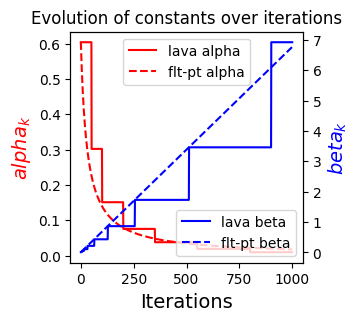

In [3]:
# Comparision of theoretical values vs practical values
fig,ax = plt.subplots(figsize=(3, 3))
plt.title("Evolution of constants over iterations")
ax.plot(alpha_lava_l, color="red", label='lava alpha')
ax.plot(alpha_l,'--', color="red", label='flt-pt alpha')
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$ alpha_k $",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_lava_l,color="blue", label='lava beta')
ax2.plot(beta_l,'--', color="blue", label='flt-pt beta')
ax2.set_ylabel("$ beta_k $",color="blue",fontsize=14)
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
plt.show()

#### Initialize Quantization Params to float default

In [2]:
def init_qz_params():
    quantization_params = {'do_quantize': False,  # => Fixed point, else floating
                       'mantissa_bits': {'Q': 8,
                                         'p': 24,
                                         'A': 8,
                                         'k': 24},
                       'single_block_exp': True,  # A single expt for entire mat
                       'weight_quantization_mode': 'nearest',  # or 'stochastic' or 'none'
                       'quantize_step_size': True,  # Quantize alpha and beta
                       'dend_accum_prec': 32,  # Precision of dend accum after mat @ vec
                       'dend_accum_rounding_mode': 'nearest',  # or 'stochastic' or 'none'
                       'dend_accum_prod_mode': 'shift'  # or 'mult'
                      }
    return quantization_params

#### Floating point solution

In [3]:
quantization_params = init_qz_params()
x_sol_float, obj_float, constraint_viol_float = \
    solve_qp(Q, p, A, k, num_iter=1000, **quantization_params)

#### Fixed point solution

In [4]:
quantization_params['do_quantize'] = True

x_sol_fixed, obj_fixed, constraint_viol_fixed = \
    solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)

/home/sumedhrr/frameworks.ai.lava.lava-loihi/.venv/src/lava-optimization/src/lava/lib/optimization/solvers/generic/qp/utils.py:63: RuntimeWarning: divide by zero encountered in log2
  expt = np.ceil(np.log2((np.abs(mat)))) - man_bits + 1


/home/sumedhrr/frameworks.ai.lava.lava-loihi/.venv/src/lava-optimization/src/lava/lib/optimization/solvers/generic/qp/utils.py:63: RuntimeWarning: divide by zero encountered in log2
  expt = np.ceil(np.log2((np.abs(mat)))) - man_bits + 1


#### Plot Single Fixed Point Run

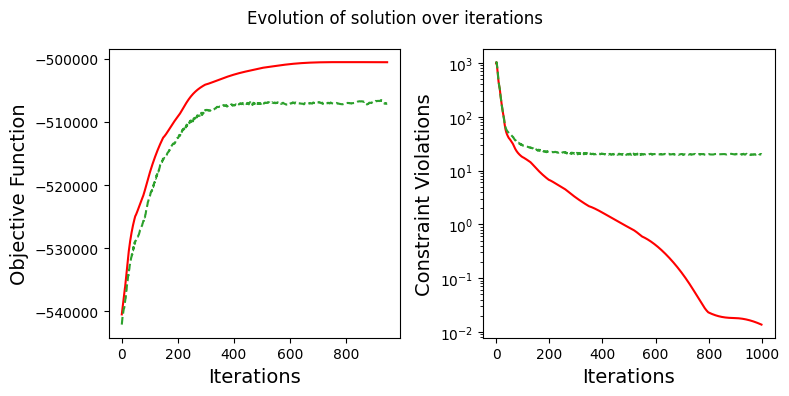

In [5]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
plt.suptitle("Evolution of solution over iterations")
ax[0].plot(obj_float[51:], color="red", label='Floating point')
ax[0].plot(obj_fixed[51:], '--', color=colours[2], label='Fixed point')
ax[1].plot(constraint_viol_float[1:], color="red", label='Floating point')
ax[1].plot(np.array(constraint_viol_fixed)[1:], '--', color=colours[2], label='Fixed point')

ax[0].set_xlabel("Iterations",fontsize=14)
ax[0].set_ylabel("Objective Function",fontsize=14)
ax[1].set_xlabel("Iterations",fontsize=14)
ax[1].set_ylabel("Constraint Violations",fontsize=14)
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

### Plots and Skews

#### Helper plotting function for skews

In [6]:
def plot_skew(skew_name, 
              flt_obj,
              flt_xnt,
              fxp_obj_list, 
              fxp_xnt_list, 
              fxp_label_list):
    colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    plt.suptitle(skew_name + " Skew")
    ax[0].plot(flt_obj[51:], color="red", label='Floating point')
    for j, os in enumerate(fxp_obj_list):
        ax[0].plot(os[51:], '--', color=colours[j], label=fxp_label_list[j])
    ax[1].plot(flt_xnt[:], color="red", label='Floating point')
    for j, cs in enumerate(fxp_xnt_list):
        ax[1].plot(np.array(cs[:]), '--', color=colours[j], label=fxp_label_list[j])

    ax[0].set_xlabel("Iterations",fontsize=14)
    ax[0].set_ylabel("Objective Function",fontsize=14)
    # ax[0].set_yscale("log")
    ax[1].set_xlabel("Iterations",fontsize=14)
    ax[1].set_ylabel("Constraint Violations",fontsize=14)
    ax[1].set_yscale("log")

    plt.legend()
    plt.tight_layout()
    plt.show()

    return fig, ax

#### Run Weight Prec Skew

In [7]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for wt_prec in [8, 16, 24, 32]:
    print(f"Solving for {wt_prec}")
    for mat_id in ['Q', 'A']:
        quantization_params['mantissa_bits'][mat_id] = wt_prec
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(str(wt_prec)+'-bit')

Solving for 8


Solving for 16
Solving for 24
Solving for 32


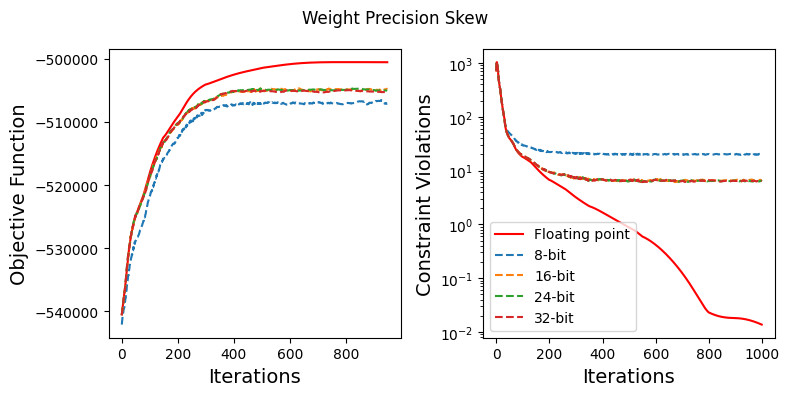

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [10]:
plot_skew('Weight Precision', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run Weight Quantization Mode Skew

In [7]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for wt_rnd_md in ['nearest', 'stochastic', 'none']:
    print(f"Solving for {wt_rnd_md}")
    quantization_params['weight_quantization_mode'] = wt_rnd_md
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(wt_rnd_md)

Solving for nearest


Solving for stochastic
Solving for none
Returning without rounding
Returning without rounding
Returning without rounding


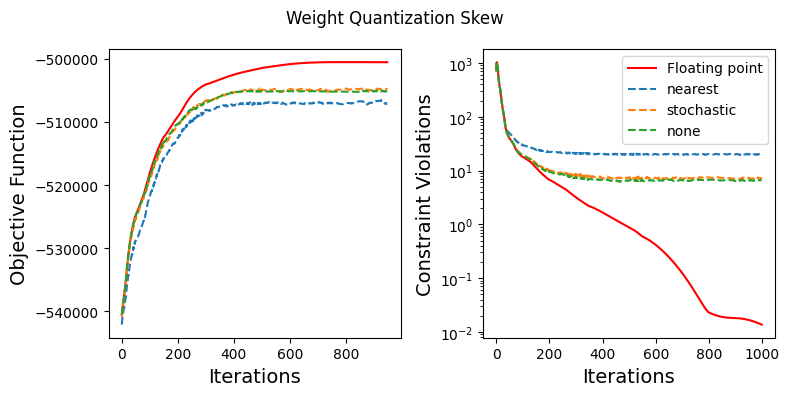

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [8]:
plot_skew('Weight Quantization', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run Block Exponent for Weights Skew

In [9]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for boolvar in [True, False]:
    print(f"Solving for single block exponent = {boolvar}")
    quantization_params['single_block_exp'] = boolvar
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(str(boolvar))

Solving for single block exponent = True


Solving for single block exponent = False


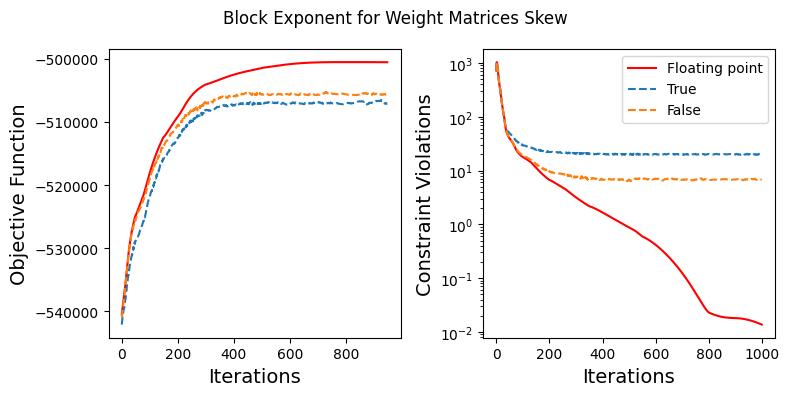

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [10]:
plot_skew('Block Exponent for Weight Matrices', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run DA Rounding Mode Skew

In [11]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for rounding in ['none', 'nearest', 'stochastic']:
    print(f"Solving for DA rounding mode: {rounding}")
    quantization_params['dend_accum_rounding_mode'] = rounding
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(rounding)

Solving for DA rounding mode: none


Solving for DA rounding mode: nearest
Solving for DA rounding mode: stochastic


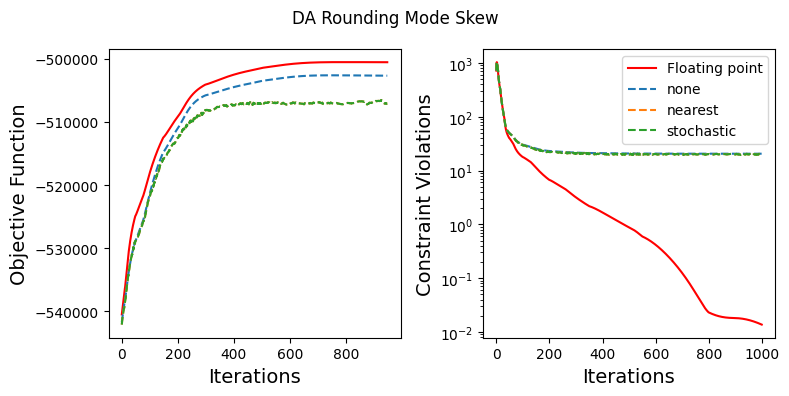

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [12]:
plot_skew('DA Rounding Mode', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run DA Prec Skew

In [13]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for da_prec in [8, 16, 24, 32]:
    print(f"Solving for {da_prec}")
    quantization_params['dend_accum_prec'] = da_prec
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(str(da_prec) + '-bit')

Solving for 8


Solving for 16
Solving for 24
Solving for 32


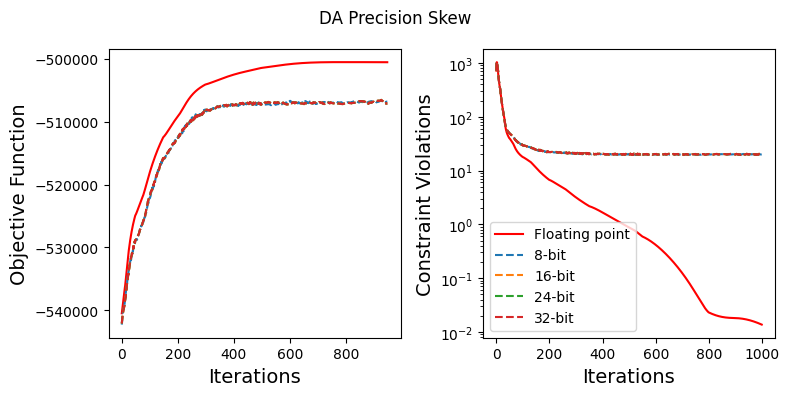

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [14]:
plot_skew('DA Precision', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run DA Prod Mode Skew

In [24]:
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
quantization_params['mantissa_bits']['Q'] = 16
quantization_params['mantissa_bits']['A'] = 16
for pm in ['shift', 'mult']:
    print(f"Solving for DA prod mode: {pm}")
    quantization_params['dend_accum_prod_mode'] = pm
    _, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    o.append(ot)
    c.append(ct)
    ll.append(pm)

Solving for DA prod mode: shift


/home/sumedhrr/frameworks.ai.lava.lava-loihi/.venv/src/lava-optimization/src/lava/lib/optimization/solvers/generic/qp/utils.py:63: RuntimeWarning: divide by zero encountered in log2
  expt = np.ceil(np.log2((np.abs(mat)))) - man_bits + 1


Solving for DA prod mode: mult


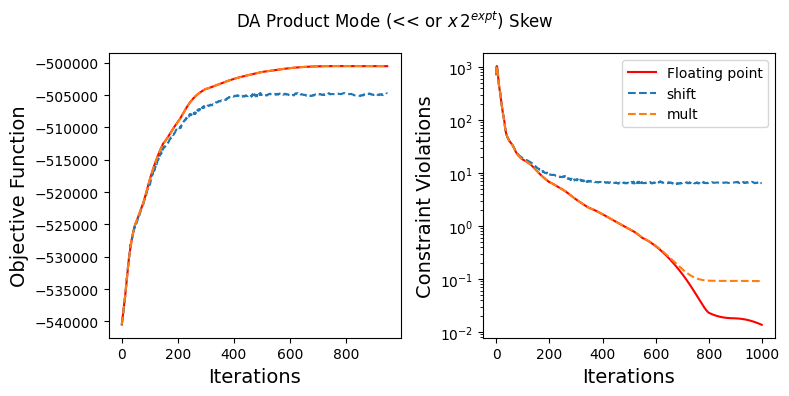

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [25]:
plot_skew('DA Product Mode (<< or $x\,2^{expt}$)', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run Single Exponent Skew

In [17]:
x = []
o = []
c = []
ll = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
for b in [True, False]:
    print(f"Solving for single block expt = {b}")
    quantization_params['single_block_exp'] = b
    xt, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    x.append(xt)
    o.append(ot)
    c.append(ct)
    ll.append(str(b))

Solving for single block expt = True


Solving for single block expt = False


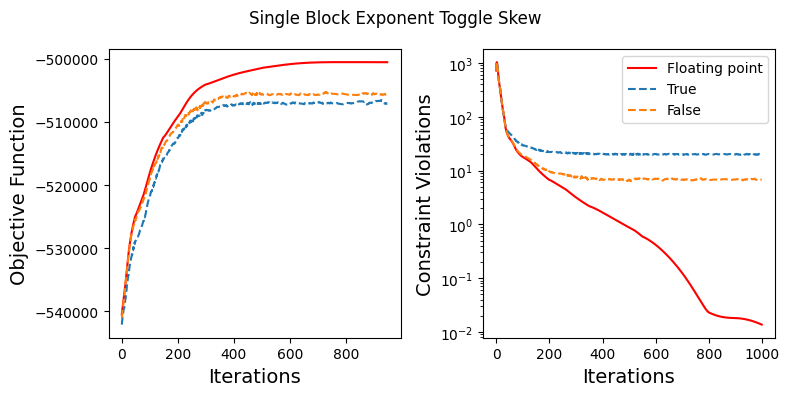

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [18]:
plot_skew('Single Block Exponent Toggle', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Best Combination Skew

Solved nearest - shift
Solved nearest - mult
Solved stochastic - shift
Solved stochastic - mult


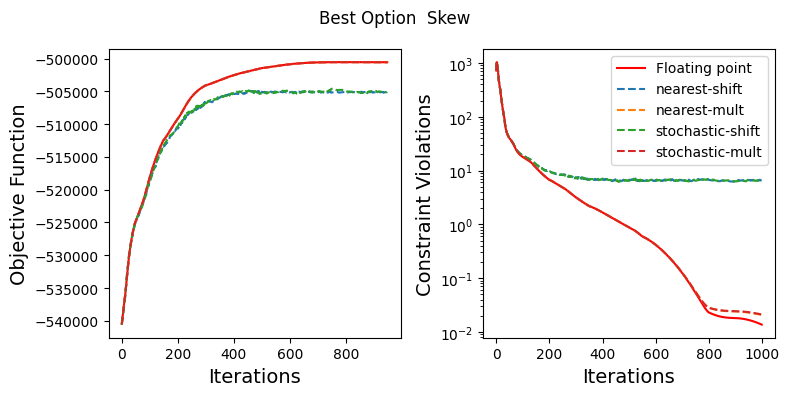

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Iterations', ylabel='Objective Function'>,
        <Axes: xlabel='Iterations', ylabel='Constraint Violations'>],
       dtype=object))

In [23]:
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
quantization_params['mantissa_bits'] = {'Q': 16,
                                        'p': 24,
                                        'A': 16,
                                        'k': 24}
quantization_params['single_block_exp'] = False
quantization_params['weight_quantization_mode'] = 'stochastic'

x = []
o = []
c = []
ll = []
for da_rnd_md in ['nearest', 'stochastic']:
    quantization_params['dend_accum_rounding_mode'] = da_rnd_md
    for da_prod_md in ['shift', 'mult']:
        quantization_params['dend_accum_prod_mode'] = da_prod_md
        xt, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
        print(f"Solved {da_rnd_md} - {da_prod_md}")
        x.append(xt)
        o.append(ot)
        c.append(ct)
        ll.append(da_rnd_md + '-' + da_prod_md)


plot_skew('Best Option ', 
          flt_obj=obj_float, flt_xnt=constraint_viol_float,
          fxp_obj_list=o, fxp_xnt_list=c, fxp_label_list=ll)

#### Run Float Emulation with Fixed Pt Code

In [9]:
x = []
o = []
c = []
quantization_params = init_qz_params()
quantization_params['do_quantize'] = True
quantization_params['single_block_exp'] = False
quantization_params['quantize_step_size'] = False
quantization_params['weight_quantization_mode'] = 'none'
quantization_params['dend_accum_prec'] = 4
for b in ['none', 'nearest', 'stochastic']:
    print(f"Solving for DA rounding mode: {b}")
    quantization_params['dend_accum_rounding_mode'] = b
    xt, ot, ct = solve_qp(Q, p, A, k, num_iter=2000, **quantization_params)
    x.append(xt)
    o.append(ot)
    c.append(ct)

Solving for none
Returning without rounding
Returning without rounding
Returning without rounding
Not quantizing the step size.


Solving for nearest
Returning without rounding
Returning without rounding
Returning without rounding
Not quantizing the step size.
Solving for stochastic
Returning without rounding
Returning without rounding
Returning without rounding
Not quantizing the step size.
